<a href="https://colab.research.google.com/github/saranshgupta121/colorization/blob/master/image_colorisation_5000_unspalsh_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.models import Sequential, Model
from keras.layers import Dense,Flatten,Conv2D,Activation
import numpy as np
from keras import layers
import keras
from keras.preprocessing import image
from keras.layers import Conv2D, UpSampling2D,MaxPooling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


In [0]:
from keras.preprocessing.image import load_img
# load an image from file
image = load_img('/content/drive/My Drive/colorization dataset 5000/cat.34.jpg', target_size=(224, 224))
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)



In [0]:
input_shape=[224,224,3]

In [6]:
vgg16 = Sequential([
Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
Conv2D(64, (3, 3), activation='relu', padding='same'),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(128, (3, 3), activation='relu', padding='same'),
Conv2D(128, (3, 3), activation='relu', padding='same',),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(256, (3, 3), activation='relu', padding='same',),
Conv2D(256, (3, 3), activation='relu', padding='same',),
Conv2D(256, (3, 3), activation='relu', padding='same',),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Flatten(),
Dense(4096, activation='relu'),
Dense(4096, activation='relu'),
Dense(1000,),
Activation('softmax')
])

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)       295168    
__________

In [0]:
vgg16.load_weights('/content/drive/My Drive/vgg16_weights.h5', by_name=True)


In [0]:
layer_name = 'dense_3'
intermediate_layer_model = Model(inputs=vgg16.input,
                                 outputs=vgg16.get_layer(layer_name).output)
vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [0]:
vgg16.graph = tf.get_default_graph()

In [0]:
X = []
for filename in os.listdir('/content/drive/My Drive/5000_random_unsplash'):
    X.append(img_to_array(load_img('/content/drive/My Drive/5000_random_unsplash/'+filename,target_size=(256, 256))))
    #print(len(X))


In [0]:
X = np.array(X,dtype=np.float32)
Xtrain = 1.0/255*X
print(len(Xtrain))
#plt.imshow(Xtrain[0])

In [0]:
embed_input = Input(shape=(1000,))
#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides =2)(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same', strides=2)(encoder_output)

#Fusion
fusion_output = RepeatVector(4 *4)(embed_input) 
fusion_output = Reshape(([4,4,1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(512, (1, 1), activation='relu', padding='same')(fusion_output)

decoder_output = Conv2DTranspose(512, (3,3), activation='relu', padding='same', strides=1)(encoder_output)
decoder_output = Conv2DTranspose(256, (3,3), activation='relu', padding='same', strides=2)(decoder_output)
decoder_output = Conv2DTranspose(256, (3,3), activation='relu', padding='same', strides=2)(decoder_output)
decoder_output = Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=2)(decoder_output)
decoder_output = BatchNormalization()(decoder_output)
decoder_output = Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=2)(decoder_output)
decoder_output = Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2)(decoder_output)
decoder_output = Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2)(decoder_output)
decoder_output = Conv2DTranspose(2, (1,1), activation='relu', padding='same', strides=1)(decoder_output)

model = Model(inputs=[encoder_input,embed_input], outputs=decoder_output)
#model = Model(inputs=[encoder_input], outputs=decoder_output)


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 256)         590080    
__________

In [0]:
def create_classifier_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (224, 224, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    #grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with vgg16.graph.as_default():
        embed = vgg16.predict(grayscaled_rgb_resized)
        embed = intermediate_layer_model.predict(grayscaled_rgb_resized)
    return embed

In [0]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 2

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_classifier_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        #yield (X_batch, Y_batch)
        yield ([X_batch,create_classifier_embedding(grayscaled_rgb)], Y_batch)

In [45]:
color_me = []
for filename in os.listdir('/content/drive/My Drive/colorization_unsplash_20_test'):
  color_me.append(img_to_array(load_img('/content/drive/My Drive/colorization_unsplash_20_test/'+filename,target_size=(256, 256))))
len(color_me)
#plt.imshow(color_me[0])

20

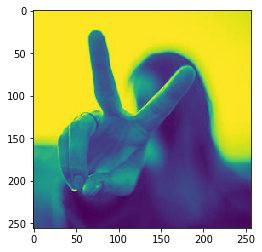

In [43]:
color_me = np.array(color_me, dtype=float)
#print(color_me.shape)

gray_me = gray2rgb(rgb2gray(color_me/255.0))
color_me_embed = create_classifier_embedding(gray_me)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me_duplicate=color_me

#color_me_duplicate=gray_me

plt.imshow(color_me[0])

In [0]:
#Train model      
model.compile(optimizer=Adam(lr=0.001), loss='mse',metrics=["accuracy"])
#model.compile(optimizer=Adam(lr=0.01), loss='mse',metrics=["accuracy"])


In [0]:
filepath="/content/drive/My Drive/image colorisation_20_unspalsh_data_results/weights.{epoch:02d}-{loss:.2f}.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=100)
callbacks_list = [checkpoint]


In [0]:
for i in range(20):
  history=model.fit_generator(image_a_b_gen(batch_size), epochs=100, steps_per_epoch=5,verbose=1,callbacks=callbacks_list)
  output = model.predict([color_me,color_me_embed])
  #output = model.predict(color_me)
  output = output * 128
  if((i+1)%2==0):
    for j in range(len(output)):
      cur = np.zeros((256, 256, 3))
      cur[:,:,0] = color_me[j][:,:,0]
      cur[:,:,1:] = output[j]
      #axarr[c,0].imshow(color_me_duplicate[i])
      imsave('/content/drive/My Drive/image colorisation_20_unspalsh_data_results/'+'epochs_'+str((i+1)*100)+'/'+'input_sketches'+str(j)+'.png',color_me_duplicate[j])
      #axarr[c][0].axis('off')
      #axarr[c,1].imshow(lab2rgb(cur))
      imsave('/content/drive/My Drive/image colorisation_20_unspalsh_data_results/'+'epochs_'+str((i+1)*100)+'/'+'output_sketches'+str(j)+'.png', lab2rgb(cur))
      #axarr[c][1].axis('off')